## Query EFD Data

In [4]:
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient
client = makeEfdClient()


In [2]:
fullPath = ['lsst.sal.ESS.airTurbulence.sonicTemperature',
           # 'lsst.sal.ESS.temperature.Air',
           # 'lsst.sal.ESS.temperature.M2',
           # 'lsst.sal.ESS.temperature.Truss',
           'lsst.sal.ATDome.position.azimuthPosition',
           'lsst.sal.ESS.airTurbulence.sonicTemperatureStdDev',
           'lsst.sal.ATDome.position.mainDoorOpeningPercentage',
           'lsst.sal.ESS.airTurbulence.sonicTemperatureStdDev',
           # 'lsst.sal.ESS.airTurbulence.Headwind',
           # 'lsst.sal.ESS.airTurbulence.Crosswind',
           'lsst.sal.ATMCS.trajectory.elevation0',
           'lsst.sal.ATMCS.trajectory.azimuth0',
           'lsst.sal.ESS.airTurbulence.speed0',
           'lsst.sal.ESS.airTurbulence.speed1',
           'lsst.sal.ESS.airTurbulence.speed2',
           # 'lsst.sal.ESS.temperature.M2 minus Air temp',
           'lsst.sal.ESS.airFlow.speed',
           'lsst.sal.ESS.temperature.temperatureItem0',
           'lsst.sal.ESS.temperature.temperatureItem1',
           'lsst.sal.ESS.temperature.temperatureItem2',
           'lsst.sal.ESS.temperature.temperatureItem3',
           'lsst.sal.ESS.temperature.temperatureItem4',
          ]
paths = []
cols = []
for col in fullPath:
    paths.append(('.').join(col.split('.')[:-1]))
    cols.append(col.split('.')[-1])

import numpy as np
columns = np.array(cols)
upaths = np.unique(paths) 
out = dict().fromkeys(upaths)
for path in upaths:
    out[path] = columns[np.array(paths)==path]
out    

{'lsst.sal.ATDome.position': array(['azimuthPosition', 'mainDoorOpeningPercentage'], dtype='<U25'),
 'lsst.sal.ATMCS.trajectory': array(['elevation0', 'azimuth0'], dtype='<U25'),
 'lsst.sal.ESS.airFlow': array(['speed'], dtype='<U25'),
 'lsst.sal.ESS.airTurbulence': array(['sonicTemperature', 'sonicTemperatureStdDev',
        'sonicTemperatureStdDev', 'speed0', 'speed1', 'speed2'],
       dtype='<U25'),
 'lsst.sal.ESS.temperature': array(['temperatureItem0', 'temperatureItem1', 'temperatureItem2',
        'temperatureItem3', 'temperatureItem4'], dtype='<U25')}

In [55]:
tables = [] 
for path, col in zip(out.keys(),out.values()):
    print(path, col)
    df = getEfdData(client, path, columns=col, dayObs=20240305)
    tables.append(df)


lsst.sal.ATDome.position ['azimuthPosition' 'mainDoorOpeningPercentage']
lsst.sal.ATMCS.trajectory ['elevation0' 'azimuth0']
lsst.sal.ESS.airFlow ['speed']
lsst.sal.ESS.airTurbulence ['sonicTemperature' 'sonicTemperatureStdDev' 'sonicTemperatureStdDev'
 'speed0' 'speed1' 'speed2']
lsst.sal.ESS.temperature ['temperatureItem0' 'temperatureItem1' 'temperatureItem2'
 'temperatureItem3' 'temperatureItem4']


In [5]:
thermal = {'lsst.sal.ATDome.position': ['azimuthPosition', 'mainDoorOpeningPercentage'],
           'lsst.sal.ATMCS.trajectory': ['elevation0', 'azimuth0'],
           'lsst.sal.ESS.airFlow': ['speed'],
           'lsst.sal.ESS.airTurbulence':['sonicTemperature', 'sonicTemperatureStdDev', 'speed0', 'speed1', 'speed2'],
           'lsst.sal.ESS.temperature': ['temperatureItem0', 'temperatureItem1', 'temperatureItem2','temperatureItem3', 'temperatureItem4']
            }


In [6]:
import pandas as pd
def get_efd_days(days, delta_t = 30):
    client = makeEfdClient()
    
    tables = []
    for now in days:
        vals = []
        for path, col in zip(thermal.keys(),thermal.values()):
            df = getEfdData(client, path, columns=col, dayObs=now, warn=False)
            vals.append(df)
        df2 = pd.DataFrame(pd.concat(vals,axis=0)).T
        tables.append(df2)
    return pd.concat(tables, ignore_index=True)


In [229]:
days = [20231214,20240130,20240305,20240306]
# df = get_efd_days(days)

In [230]:
tables = []
for now in days:
    vals = []
    for path, col in zip(thermal.keys(),thermal.values()):
        df = getEfdData(client, path, columns=col, dayObs=now, warn=False)
        vals.append(df)
    df2 = pd.concat(vals)
    df2 = df2.resample('5min').mean()
    df2.index = df2.index.tz_convert('America/Santiago')
    tables.append(df2)

In [268]:
df = tables[2]
df['deltaTemp_M1M2'] = df.temperatureItem0 - df.temperatureItem2

t0 = getDomeOpeningTime(df, fracTh=95)
# Querying the value of deltaTemp_M1M2 at first_open_time
delta_temp_at_open_time = df.loc[t0, 'deltaTemp_M1M2']

# Querying the value of deltaTemp_M1M2 6 hours before first_open_time
six_hours_before_open_time = t0 - pd.Timedelta(hours=6)
delta_temp_six_hours_before = df.loc[six_hours_before_open_time, 'deltaTemp_M1M2']

print("DeltaTemp_M1M2 at first_open_time:", delta_temp_at_open_time)
print("DeltaTemp_M1M2 6 hours before first_open_time:", delta_temp_six_hours_before)



DeltaTemp_M1M2 at first_open_time: -2.5197226784598357
DeltaTemp_M1M2 6 hours before first_open_time: -4.355025993123629


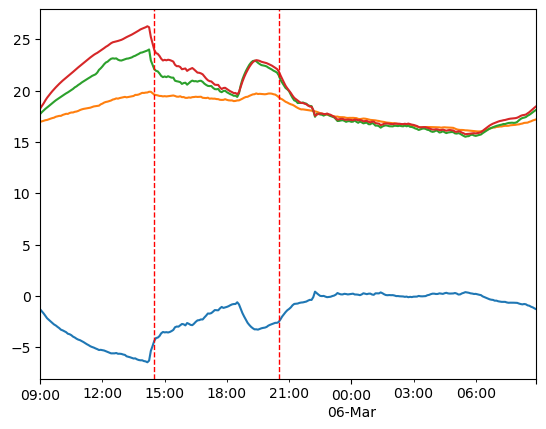

In [269]:
# t0 = df.night_start[0]

df.deltaTemp_M1M2.plot()
df.temperatureItem0.plot()
df.temperatureItem1.plot()
df.temperatureItem2.plot()
# df.temperatureItem3.plot()

# df.speed.plot()
plt.axvline(x=t0, color='red', linestyle='--', linewidth=1)
plt.axvline(x=t0-pd.Timedelta(hours=6), color='red', linestyle='--', linewidth=1)

In [270]:
def get_max_value_window(df, col, timeDelta=6.):
    first_open_time = df.night_start[0]
    
    # Define the time window
    start_time_window = first_open_time - pd.Timedelta(hours=timeDelta)
    end_time_window = first_open_time
    
    # Filter the dataframe for the time window
    time_window_df = df.loc[start_time_window:end_time_window]
    
    # Find the maximum value of deltaTemp_M1M2
    max_delta_temp_six_hours_before = time_window_df[col].max()
    max_delta_temp_time = time_window_df[col].idxmax()
    time_difference_hours = (first_open_time - max_delta_temp_time).total_seconds() / 3600
    print("Maximum value of %s during the time window of six hours before first_open_time:"%col, time_difference_hours)

    return max_delta_temp_six_hours_before, time_difference_hours

df = tables[1]
df['night_start'] = getDomeOpeningTime(df, fracTh=95)
df['deltaTemp_M1M2'] = df.temperatureItem0 - df.temperatureItem2
deltaTempMax, deltaTimeMax = get_max_value_window(df, 'deltaTemp_M1M2')

Maximum value of deltaTemp_M1M2 during the time window of six hours before first_open_time: 0.0


/tmp/ipykernel_3041/1047605764.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_open_time = df.night_start[0]


In [78]:
from scipy.interpolate import interp1d

def interpolate_time_series(df, times, col):
    intFunc = interp1d(df.index.to_numpy().astype(np.datetime64), df[col], kind='linear', fill_value='extrapolate')
    return intFunc(times)


In [258]:
days = [20231214,20240130,20240305,20240306,20240307]
for day in days:
    queryEFDThermalInfo(day)

In [257]:
def queryEFDThermalInfo(day, domeFrac=95):
    # get the efd of the day
    efd = get_efd_day(day)

    # start of operation time
    efd['night_t0']  = get_night_start_time(efd, fracTh=domeFrac)

    # bin the night time in 4 periods of 2.5 hours
    efd['night_period']  = getPeriodsNight(efd)
    
    # Define the Delta Temperature of M1, M2
    efd['deltaTempM1M2'] = efd.temperatureItem0 - efd.temperatureItem2

    # get Max \Delta Temp. of M1 M2 in a window of 6 hours prior to operations (night_t0)
    deltaTempMax, deltaTimeMax = get_max_value_window(efd, 'deltaTempM1M2')
    efd['deltaTempM1M2_night_t0_value'] = interpolate_time_series(efd, 'deltaTempM1M2', efd['night_t0'].iloc[0])
    efd['deltaTempM1M2_day_value'] = deltaTempMax
    efd['deltaTempM1M2_day_time'] = deltaTimeMax

    # M2 Temperature
    M2TempMax, M2deltaTimeMax = get_max_value_window(efd, 'temperatureItem2')
    efd['M2_night_t0_value'] = interpolate_time_series(efd, 'temperatureItem2', efd['night_t0'].iloc[0])
    efd['M2_day_value'] = deltaTempMax
    efd['M2_day_time'] = deltaTimeMax

    # save the efd
    efd.to_csv('./data/efd/efd_thermal_data_%s.csv'%day)

def interpolate_time_series(df, col, given_time):
    # Interpolate deltaTemp_M1M2 for any given time
    # given_time = pd.Timestamp('2024-04-16 20:30:00')  # Example given time
    # interpolated_value_at_given_time = df['deltaTemp_M1M2'].interpolate(method='time').loc[given_time]
    # print("Interpolated value of deltaTemp_M1M2 at given time:", interpolated_value_at_given_time)
    return df[col].interpolate(method='time').loc[given_time]

def get_efd_day(day):
    client = makeEfdClient()
    vals = []
    for path, col in zip(thermal.keys(),thermal.values()):
        df = getEfdData(client, path, columns=col, dayObs=day, warn=False)
        vals.append(df)
    df2 = pd.concat(vals)
    df2 = df2.resample('1min').mean()
    df2.index = df2.index.tz_convert('America/Santiago')
    return df2

def get_night_start_time(df, fracTh=95):
    """Get the time when the dome was opened
    in a time window of 6pm to 10pm local time
    """
    # Step 1: Filter the dataframe to the time window between 18:00 to 22:00
    time_window_df = df.between_time('18:00', '22:00')
    
    # Step 2: Find the first occurrence where mainDoorOpeningPercentage >= 95%
    first_open_time = time_window_df.index[time_window_df['mainDoorOpeningPercentage'] >= fracTh].min()
    return first_open_time

def getPeriodsNight(df,deltaTime=2.5):
    """ Divide the night in 4 periods of 2.5 hours

    Day is 0:, 
    First Night Period is 1, 
    and so on...
    """
    first_open_time = df.night_t0.iloc[0]
    # Step 1: Create a new column to indicate the time period
    df['night_period'] = 0
    
    # Step 2: Assign 0 for daytime (before first_open_time)
    df.loc[df.index < first_open_time, 'night_period'] = 0
    
    # Step 3: Assign values 1, 2, 3, and 4 for each of the four 3-hour periods during the night
    night_period_start = first_open_time
    for i in range(1, 5):
        night_period_end = night_period_start + pd.Timedelta(hours=deltaTime)
        df.loc[(df.index >= night_period_start) & (df.index < night_period_end), 'night_period'] = i
        night_period_start = night_period_end

    return df['night_period'].to_numpy()

def get_max_value_window(df, col, deltaTime=6.):
    first_open_time = df.night_t0.iloc[0]
    
    # Define the time window
    start_time_window = first_open_time - pd.Timedelta(hours=deltaTime)
    end_time_window = first_open_time
    
    # Filter the dataframe for the time window
    time_window_df = df.loc[start_time_window:end_time_window]
    
    # Find the maximum value of deltaTemp_M1M2
    max_delta_temp_six_hours_before = time_window_df[col].max()
    max_delta_temp_time = time_window_df[col].idxmax()
    time_difference_hours = (first_open_time - max_delta_temp_time).total_seconds() / 3600
    # print("Maximum value of %s during the time window of six hours before first_open_time:"%col, time_difference_hours)

    return max_delta_temp_six_hours_before, max_delta_temp_time


In [46]:
day = 20240130
# '../data/gaia_matched_%s*'%(day)

In [48]:
import glob
fnames = glob.glob('../data/gaia_matched_%s*'%(day))
# fnames

In [72]:
efd.index[950]

Timestamp('2024-01-31 03:50:00')

In [264]:
efd_fname = '../data/efd/efd_thermal_data_%s.csv'%(day)
efd = pd.read_csv(efd_fname, index_col=0, parse_dates=True)


In [247]:
from astropy.time import Time
import numpy as np

# def math_efd(df, expID):
# day = int(expID[:8])
df = pd.read_csv(fnames[0], parse_dates=True, index_col=0)
efd_fname = '../data/efd/efd_thermal_data_%s.csv'%(day)
efd = pd.read_csv(efd_fname,index_col=0, parse_dates=True)

times = pd.Series(index=Time(np.array(df.DATE).astype(np.datetime64), scale='utc'))[0]
columns = list(efd.columns)
efd.index = efd.index.tz_convert(None)

# for col in columns:
#     df[col] = interpolate_time_series(efd, col, times[0])
#     # return df

/tmp/ipykernel_717/3404468448.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(fnames[0], parse_dates=True, index_col=0)
/tmp/ipykernel_717/3404468448.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  times = pd.Series(index=Time(np.array(df.DATE).astype(np.datetime64), scale='utc'))[0]


In [249]:
def match_efd_exposure(df,efd):
    lookup = pd.Timestamp(df.DATE.loc[0])
    output = efd.iloc[efd.index.searchsorted(lookup) - 1]
    for col in columns:
        df[col] = output[col]
    return df

In [252]:
df

,ref_id,ref_coord_ra,ref_coord_dec,ref_phot_g_mean_flux,ref_phot_g_mean_fluxErr,ref_centroid_x,ref_centroid_y,src_coord_ra,src_coord_dec,src_base_SdssCentroid_x,...,speed2,night_t0,night_period,deltaTempM1M2,deltaTempM1M2_night_t0_value,deltaTempM1M2_day_value,deltaTempM1M2_day_time,M2_night_t0_value,M2_day_value,M2_day_time
0,5544602466173107200,2.137520,-0.632810,6.036270e+05,352.251555,2715.786404,51.088076,2.137520,-0.632810,2715.756725,...,-0.471315,2024-01-30 20:48:00-03:00,2,2.010323,1.034777,1.034777,2024-01-30 20:48:00-03:00,20.289201,1.034777,2024-01-30 20:48:00-03:00
1,5544602363087962496,2.136789,-0.632809,6.938575e+05,426.653262,1445.016918,68.123870,2.136789,-0.632809,1444.869152,...,-0.471315,2024-01-30 20:48:00-03:00,2,2.010323,1.034777,1.034777,2024-01-30 20:48:00-03:00,20.289201,1.034777,2024-01-30 20:48:00-03:00
2,5544602328733107712,2.136617,-0.632781,9.808385e+05,407.762411,1146.202814,131.914096,2.136617,-0.632782,1146.102558,...,-0.471315,2024-01-30 20:48:00-03:00,2,2.010323,1.034777,1.034777,2024-01-30 20:48:00-03:00,20.289201,1.034777,2024-01-30 20:48:00-03:00
3,5544603084647360384,2.136360,-0.632785,1.734555e+07,2152.535259,699.610439,129.153744,2.136360,-0.632785,699.641112,...,-0.471315,2024-01-30 20:48:00-03:00,2,2.010323,1.034777,1.034777,2024-01-30 20:48:00-03:00,20.289201,1.034777,2024-01-30 20:48:00-03:00
4,5544603050287636352,2.136007,-0.632772,5.045015e+05,334.066330,85.635108,165.170267,2.136007,-0.632772,85.802916,...,-0.471315,2024-01-30 20:48:00-03:00,2,2.010323,1.034777,1.034777,2024-01-30 20:48:00-03:00,20.289201,1.034777,2024-01-30 20:48:00-03:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,5544609647357610112,2.137673,-0.631131,2.248026e+07,17321.252132,3030.097578,3664.113842,2.137673,-0.631132,3029.902238,...,-0.471315,2024-01-30 20:48:00-03:00,2,2.010323,1.034777,1.034777,2024-01-30 20:48:00-03:00,20.289201,1.034777,2024-01-30 20:48:00-03:00
67,5544606898578291072,2.136065,-0.631108,9.573038e+05,432.168231,232.076588,3750.834891,2.136065,-0.631108,232.067127,...,-0.471315,2024-01-30 20:48:00-03:00,2,2.010323,1.034777,1.034777,2024-01-30 20:48:00-03:00,20.289201,1.034777,2024-01-30 20:48:00-03:00
68,5544609681717038208,2.138132,-0.631079,6.502589e+05,374.537927,3830.364774,3766.428330,2.138132,-0.631079,3830.584538,...,-0.471315,2024-01-30 20:48:00-03:00,2,2.010323,1.034777,1.034777,2024-01-30 20:48:00-03:00,20.289201,1.034777,2024-01-30 20:48:00-03:00
69,5544609681717048064,2.137865,-0.631119,3.928135e+08,71396.256282,3363.813922,3687.456625,2.137865,-0.631119,3363.834155,...,-0.471315,2024-01-30 20:48:00-03:00,2,2.010323,1.034777,1.034777,2024-01-30 20:48:00-03:00,20.289201,1.034777,2024-01-30 20:48:00-03:00


In [234]:
date_series = pd.to_datetime(df.DATE) 
date_series

0    2024-01-31 03:48:18.252
1    2024-01-31 03:48:18.252
2    2024-01-31 03:48:18.252
3    2024-01-31 03:48:18.252
4    2024-01-31 03:48:18.252
               ...          
66   2024-01-31 03:48:18.252
67   2024-01-31 03:48:18.252
68   2024-01-31 03:48:18.252
69   2024-01-31 03:48:18.252
70   2024-01-31 03:48:18.252
Name: DATE, Length: 71, dtype: datetime64[ns]

In [265]:
help(pd.concat)

Help on function concat in module pandas.core.reshape.concat:

concat(objs: 'Iterable[Series | DataFrame] | Mapping[HashableT, Series | DataFrame]', *, axis: 'Axis' = 0, join: 'str' = 'outer', ignore_index: 'bool' = False, keys=None, levels=None, names: 'list[HashableT] | None' = None, verify_integrity: 'bool' = False, sort: 'bool' = False, copy: 'bool | None' = None) -> 'DataFrame | Series'
    Concatenate pandas objects along a particular axis.
    
    Allows optional set logic along the other axes.
    
    Can also add a layer of hierarchical indexing on the concatenation axis,
    which may be useful if the labels are the same (or overlapping) on
    the passed axis number.
    
    Parameters
    ----------
    objs : a sequence or mapping of Series or DataFrame objects
        If a mapping is passed, the sorted keys will be used as the `keys`
        argument, unless it is passed, in which case the values will be
        selected (see below). Any None objects will be dropped si

In [246]:
# def math_exposure_efd(efd):
#     # Step 1: Convert date_series to DataFrame with 'DATE' as index
#     date_df = pd.DataFrame({'DATE': date_series}).set_index('DATE')
    
#     # Step 2: Merge date_df with efd DataFrame
#     merged_df = date_df.merge(efd, left_index=True, right_index=True, how='outer')
    
#     # Step 3: Interpolate missing values
#     interpolated_df = merged_df.interpolate(method='time')
    
#     # Step 4: Remove duplicates from the interpolated DataFrame
#     interpolated_df = interpolated_df[~interpolated_df.index.duplicated(keep='first')].loc[date_df.index]
#     interpolated_df.index = np.arange(len(interpolated_df))
#     return interpolated_df

In [241]:
interpolated_df = math_exposure_efd(efd)
interpolated_df

/tmp/ipykernel_717/3567450913.py:9: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_df = merged_df.interpolate(method='time')


,azimuthPosition,mainDoorOpeningPercentage,elevation0,azimuth0,speed,sonicTemperature,sonicTemperatureStdDev,speed0,speed1,speed2,...,temperatureItem4,night_t0,night_period,deltaTempM1M2,deltaTempM1M2_night_t0_value,deltaTempM1M2_day_value,deltaTempM1M2_day_time,M2_night_t0_value,M2_day_value,M2_day_time
0,124.02,100.0,81.983397,140.04058,11.0563,19.273971,0.087745,-0.362452,0.051881,-0.423247,...,21.441847,NaN,2.0,2.002838,1.034777,1.034777,NaN,20.289201,1.034777,NaN
1,124.02,100.0,81.983397,140.04058,11.0563,19.273971,0.087745,-0.362452,0.051881,-0.423247,...,21.441847,NaN,2.0,2.002838,1.034777,1.034777,NaN,20.289201,1.034777,NaN
2,124.02,100.0,81.983397,140.04058,11.0563,19.273971,0.087745,-0.362452,0.051881,-0.423247,...,21.441847,NaN,2.0,2.002838,1.034777,1.034777,NaN,20.289201,1.034777,NaN
3,124.02,100.0,81.983397,140.04058,11.0563,19.273971,0.087745,-0.362452,0.051881,-0.423247,...,21.441847,NaN,2.0,2.002838,1.034777,1.034777,NaN,20.289201,1.034777,NaN
4,124.02,100.0,81.983397,140.04058,11.0563,19.273971,0.087745,-0.362452,0.051881,-0.423247,...,21.441847,NaN,2.0,2.002838,1.034777,1.034777,NaN,20.289201,1.034777,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,124.02,100.0,81.983397,140.04058,11.0563,19.273971,0.087745,-0.362452,0.051881,-0.423247,...,21.441847,NaN,2.0,2.002838,1.034777,1.034777,NaN,20.289201,1.034777,NaN
67,124.02,100.0,81.983397,140.04058,11.0563,19.273971,0.087745,-0.362452,0.051881,-0.423247,...,21.441847,NaN,2.0,2.002838,1.034777,1.034777,NaN,20.289201,1.034777,NaN
68,124.02,100.0,81.983397,140.04058,11.0563,19.273971,0.087745,-0.362452,0.051881,-0.423247,...,21.441847,NaN,2.0,2.002838,1.034777,1.034777,NaN,20.289201,1.034777,NaN
69,124.02,100.0,81.983397,140.04058,11.0563,19.273971,0.087745,-0.362452,0.051881,-0.423247,...,21.441847,NaN,2.0,2.002838,1.034777,1.034777,NaN,20.289201,1.034777,NaN


In [245]:
efd

,azimuthPosition,mainDoorOpeningPercentage,elevation0,azimuth0,speed,sonicTemperature,sonicTemperatureStdDev,speed0,speed1,speed2,...,temperatureItem4,night_t0,night_period,deltaTempM1M2,deltaTempM1M2_night_t0_value,deltaTempM1M2_day_value,deltaTempM1M2_day_time,M2_night_t0_value,M2_day_value,M2_day_time
2024-01-30 12:00:00,NaN,NaN,NaN,NaN,1.460686,29.553650,0.025942,0.029100,-0.008475,0.031510,...,20.701100,2024-01-30 20:48:00-03:00,0,-3.747057,1.034777,1.034777,2024-01-30 20:48:00-03:00,20.289201,1.034777,2024-01-30 20:48:00-03:00
2024-01-30 12:01:00,NaN,NaN,NaN,NaN,1.853857,29.619289,0.022838,0.027985,-0.007860,0.036390,...,20.703587,2024-01-30 20:48:00-03:00,0,-3.754205,1.034777,1.034777,2024-01-30 20:48:00-03:00,20.289201,1.034777,2024-01-30 20:48:00-03:00
2024-01-30 12:02:00,NaN,NaN,NaN,NaN,1.986343,29.664295,0.050294,0.027025,-0.006075,0.036415,...,20.707012,2024-01-30 20:48:00-03:00,0,-3.758810,1.034777,1.034777,2024-01-30 20:48:00-03:00,20.289201,1.034777,2024-01-30 20:48:00-03:00
2024-01-30 12:03:00,NaN,NaN,NaN,NaN,1.819543,29.720930,0.041196,0.028895,-0.006100,0.026555,...,20.710162,2024-01-30 20:48:00-03:00,0,-3.772813,1.034777,1.034777,2024-01-30 20:48:00-03:00,20.289201,1.034777,2024-01-30 20:48:00-03:00
2024-01-30 12:04:00,NaN,NaN,NaN,NaN,1.867914,29.789520,0.014772,0.029830,-0.008175,0.024815,...,20.713263,2024-01-30 20:48:00-03:00,0,-3.914681,1.034777,1.034777,2024-01-30 20:48:00-03:00,20.289201,1.034777,2024-01-30 20:48:00-03:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 11:55:00,NaN,NaN,NaN,NaN,6.930771,23.178740,0.063554,0.024550,-0.009560,0.043150,...,20.158615,2024-01-30 20:48:00-03:00,0,-1.560766,1.034777,1.034777,2024-01-30 20:48:00-03:00,20.289201,1.034777,2024-01-30 20:48:00-03:00
2024-01-31 11:56:00,NaN,NaN,NaN,NaN,8.001629,23.258209,0.031563,0.017320,-0.029505,0.029480,...,20.158705,2024-01-30 20:48:00-03:00,0,-1.582406,1.034777,1.034777,2024-01-30 20:48:00-03:00,20.289201,1.034777,2024-01-30 20:48:00-03:00
2024-01-31 11:57:00,NaN,NaN,NaN,NaN,8.298057,23.202641,0.076718,0.024915,-0.028035,0.027815,...,20.160227,2024-01-30 20:48:00-03:00,0,-1.601985,1.034777,1.034777,2024-01-30 20:48:00-03:00,20.289201,1.034777,2024-01-30 20:48:00-03:00
2024-01-31 11:58:00,NaN,NaN,NaN,NaN,7.288914,23.293409,0.102906,0.014865,-0.018815,0.026190,...,20.160255,2024-01-30 20:48:00-03:00,0,-1.613425,1.034777,1.034777,2024-01-30 20:48:00-03:00,20.289201,1.034777,2024-01-30 20:48:00-03:00


In [244]:
df.merge(interpolated_df, left_index=True, right_index=True,)

,ref_id,ref_coord_ra,ref_coord_dec,ref_phot_g_mean_flux,ref_phot_g_mean_fluxErr,ref_centroid_x,ref_centroid_y,src_coord_ra,src_coord_dec,src_base_SdssCentroid_x,...,temperatureItem4_y,night_t0,night_period,deltaTempM1M2,deltaTempM1M2_night_t0_value,deltaTempM1M2_day_value,deltaTempM1M2_day_time,M2_night_t0_value,M2_day_value,M2_day_time
0,5544602466173107200,2.137520,-0.632810,6.036270e+05,352.251555,2715.786404,51.088076,2.137520,-0.632810,2715.756725,...,21.441847,NaN,2.0,2.002838,1.034777,1.034777,NaN,20.289201,1.034777,NaN
1,5544602363087962496,2.136789,-0.632809,6.938575e+05,426.653262,1445.016918,68.123870,2.136789,-0.632809,1444.869152,...,21.441847,NaN,2.0,2.002838,1.034777,1.034777,NaN,20.289201,1.034777,NaN
2,5544602328733107712,2.136617,-0.632781,9.808385e+05,407.762411,1146.202814,131.914096,2.136617,-0.632782,1146.102558,...,21.441847,NaN,2.0,2.002838,1.034777,1.034777,NaN,20.289201,1.034777,NaN
3,5544603084647360384,2.136360,-0.632785,1.734555e+07,2152.535259,699.610439,129.153744,2.136360,-0.632785,699.641112,...,21.441847,NaN,2.0,2.002838,1.034777,1.034777,NaN,20.289201,1.034777,NaN
4,5544603050287636352,2.136007,-0.632772,5.045015e+05,334.066330,85.635108,165.170267,2.136007,-0.632772,85.802916,...,21.441847,NaN,2.0,2.002838,1.034777,1.034777,NaN,20.289201,1.034777,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,5544609647357610112,2.137673,-0.631131,2.248026e+07,17321.252132,3030.097578,3664.113842,2.137673,-0.631132,3029.902238,...,21.441847,NaN,2.0,2.002838,1.034777,1.034777,NaN,20.289201,1.034777,NaN
67,5544606898578291072,2.136065,-0.631108,9.573038e+05,432.168231,232.076588,3750.834891,2.136065,-0.631108,232.067127,...,21.441847,NaN,2.0,2.002838,1.034777,1.034777,NaN,20.289201,1.034777,NaN
68,5544609681717038208,2.138132,-0.631079,6.502589e+05,374.537927,3830.364774,3766.428330,2.138132,-0.631079,3830.584538,...,21.441847,NaN,2.0,2.002838,1.034777,1.034777,NaN,20.289201,1.034777,NaN
69,5544609681717048064,2.137865,-0.631119,3.928135e+08,71396.256282,3363.813922,3687.456625,2.137865,-0.631119,3363.834155,...,21.441847,NaN,2.0,2.002838,1.034777,1.034777,NaN,20.289201,1.034777,NaN


In [239]:
# pd.m([df,interpolated_df])

AttributeError: module 'pandas' has no attribute 'm'

In [215]:
# Step 4: Remove duplicates from the interpolated DataFrame
interpolated_df = interpolated_df[~interpolated_df.index.duplicated(keep='first')]

# Step 5: Filter interpolated values corresponding to date_df.index
interpolated_values = interpolated_df.loc[date_df.index, 'deltaTempM1M2']
interpolated_values

DATE
2024-01-31 03:48:18.252    2.002838
2024-01-31 03:48:18.252    2.002838
2024-01-31 03:48:18.252    2.002838
2024-01-31 03:48:18.252    2.002838
2024-01-31 03:48:18.252    2.002838
                             ...   
2024-01-31 03:48:18.252    2.002838
2024-01-31 03:48:18.252    2.002838
2024-01-31 03:48:18.252    2.002838
2024-01-31 03:48:18.252    2.002838
2024-01-31 03:48:18.252    2.002838
Name: deltaTempM1M2, Length: 71, dtype: float64

In [210]:
interpolated_values.loc[date_df.index[0]].iloc[0]

2.002837558766214

In [161]:
# times = Time(np.array(df.DATE).astype(np.datetime64), scale='utc')
times.index[0]

<Time object: scale='utc' format='datetime64' value=2024-01-31T03:48:18.252000000>

In [165]:
def get_time_series_value(df, t0, col, deltaTimeSec=2):
    # Define the time window
    end_time_window = t0 - pd.Timedelta(minutes=2)
    start_time_window = t0
    # Filter the dataframe for the time window
    time_window_df = df.loc[start_time_window:end_time_window].mean()
    return time_window_df

get_time_series_value(df, times.index, 'azimuthPosition')

InvalidIndexError: Index([2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000, 2024-01-31T03:48:18.252000000,
       2024-01-31T03:48:18.252000000],
      dtype='object')

In [148]:
# help(pd.Timedelta)

In [149]:
# from scipy.interpolate import interp1d

# def interpolate_time_series_inte(df, times, col):
#     print(col)
#     xtime = df.index.to_numpy().astype(np.datetime64)
#     values = df[col].to_numpy()
#     intFunc = interp1d(xtime, values,
#                        kind='linear', fill_value='extrapolate')
#     return intFunc(times)

def interpolate_time_series(df, col, given_time):
    # Interpolate deltaTemp_M1M2 for any given time
    # given_time = pd.Timestamp('2024-04-16 20:30:00')  # Example given time
    # interpolated_value_at_given_time = df['deltaTemp_M1M2'].interpolate(method='time').loc[given_time]
    # print("Interpolated value of deltaTemp_M1M2 at given time:", interpolated_value_at_given_time)
    return df[col].interpolate(method='time').loc[given_time]
    

In [105]:
efd['night_t0']

2024-01-30 12:00:00    2024-01-30 20:48:00-03:00
2024-01-30 12:01:00    2024-01-30 20:48:00-03:00
2024-01-30 12:02:00    2024-01-30 20:48:00-03:00
2024-01-30 12:03:00    2024-01-30 20:48:00-03:00
2024-01-30 12:04:00    2024-01-30 20:48:00-03:00
                                 ...            
2024-01-31 11:55:00    2024-01-30 20:48:00-03:00
2024-01-31 11:56:00    2024-01-30 20:48:00-03:00
2024-01-31 11:57:00    2024-01-30 20:48:00-03:00
2024-01-31 11:58:00    2024-01-30 20:48:00-03:00
2024-01-31 11:59:00    2024-01-30 20:48:00-03:00
Name: night_t0, Length: 1440, dtype: object

In [137]:
# import numpy as np
# from scipy.interpolate import interp1d

# # Assuming 'times' is a NumPy array containing datetime-like objects
# # and 'values' is a NumPy array containing the corresponding values
# # Here, times represents the timestamp data from df.DATE and values represent the deltaTemp_M1M2 data from efd
# values = efd.deltaTempM1M2.to_numpy()
# times = efd.index.to_numpy()

# times_numeric = times.astype(np.datetime_data)


# # Create a DataFrame with 'values' as the column and 'times' as the index
# df_interp = pd.DataFrame({'deltaTemp_M1M2': values}, index=times_numeric)

# # Perform interpolation
# interpolated_function = interp1d(times_numeric, values, kind='linear')

# # Define the array of specific times you want to interpolate for
# specific_times = np.array(df.DATE).astype(np.datetime64)

# # Interpolate the values at the specific times
# interpolated_values_at_specific_times = interpolated_function(specific_times)

# print("Interpolated values at specific times:", interpolated_values_at_specific_times)


In [ ]:
interpolated_values_at_specific_times[0]

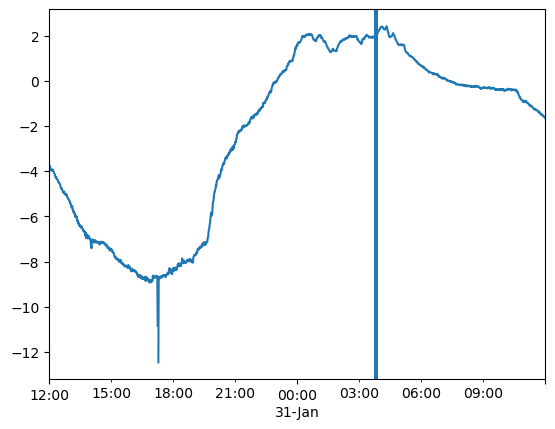

In [134]:
efd.deltaTempM1M2.plot()
for t0 in specific_times:
    plt.axvline(t0)
plt.show()

In [107]:
# df.tz_convert('America/Santiago')

In [202]:
deltaTempMax, deltaTimeMax

(-0.6040684399694811, 2.0)

In [179]:
max_delta_temp_time

Timestamp('2024-03-06 19:20:00-0300', tz='America/Santiago')

In [178]:
time_difference_hours

2.5833333333333335

In [146]:
# t0

In [183]:
def getDomeOpeningTime(df, fracTh=95):
    # Step 1: Filter the dataframe to the time window between 18:00 to 22:00
    time_window_df = df.between_time('18:00', '22:00')
    
    # Step 2: Find the first occurrence where mainDoorOpeningPercentage >= 95%
    first_open_time = time_window_df.index[time_window_df['mainDoorOpeningPercentage'] >= fracTh].min()
    return first_open_time

def getPeriodsNight(df,dT=2.5):
    # Step 1: Create a new column to indicate the time period
    df['night_period'] = 0
    
    # Step 2: Assign 0 for daytime (before first_open_time)
    df.loc[df.index < first_open_time, 'night_period'] = 0
    
    # Step 3: Assign values 1, 2, 3, and 4 for each of the four 3-hour periods during the night
    night_period_start = first_open_time
    for i in range(1, 5):
        night_period_end = night_period_start + pd.Timedelta(hours=dT)
        df.loc[(df.index >= night_period_start) & (df.index < night_period_end), 'night_period'] = i
        night_period_start = night_period_end

    return df['night_period']

In [155]:
# df.index

In [130]:
first_open_time

Timestamp('2024-03-06 21:55:00-0300', tz='America/Santiago')

In [131]:
# Step 1: Create a new column to indicate the time period
df['night_period'] = 0

# Step 2: Assign 0 for daytime (before first_open_time)
df.loc[df.index < first_open_time, 'night_period'] = 0

# Step 3: Assign values 1, 2, 3, and 4 for each of the four 3-hour periods during the night
night_period_start = first_open_time
for i in range(1, 5):
    night_period_end = night_period_start + pd.Timedelta(hours=2.5)
    df.loc[(df.index >= night_period_start) & (df.index < night_period_end), 'night_period'] = i
    night_period_start = night_period_end


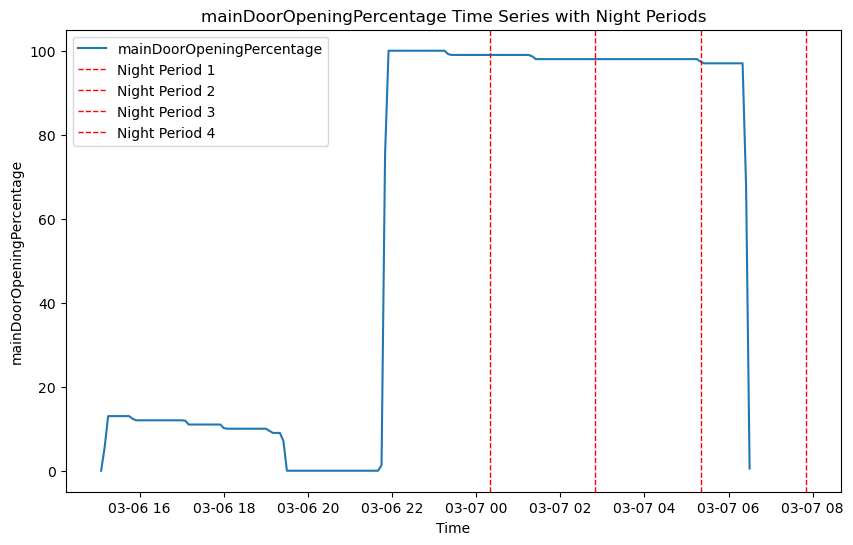

In [132]:
# Plot the mainDoorOpeningPercentage time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['mainDoorOpeningPercentage'], label='mainDoorOpeningPercentage')

# Overlay red vertical lines indicating the beginning of each night period
for i in range(1, 5):
    period_start = df[df['night_period'] == i].index[-1]
    plt.axvline(x=period_start, color='red', linestyle='--', linewidth=1, label=f'Night Period {i}')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('mainDoorOpeningPercentage')
plt.title('mainDoorOpeningPercentage Time Series with Night Periods')
plt.legend()

# Show plot
plt.show()

In [ ]:
def find_operation_start():
    pass



In [119]:
%matplotlib inline


In [120]:
import matplotlib.pyplot as plt
dome = tables[0]
air = tables[2]

air = air.resample('20min').mean()
air.index = air.index.tz_convert('America/Santiago')

dome = dome.resample('5min').mean()
dome.index = dome.index.tz_convert('America/Santiago')

air.speed.plot()
# dome.mainDoorOpeningPercentage.plot()

# plt.show()

NameError: name 'tables' is not defined

In [9]:
from astropy.time import Time,TimeDelta
delta_t = 5
dt_begin = TimeDelta(delta_t, format='sec')
dt_end = TimeDelta(delta_t, format='sec')
now = Time('2023-11-18T18:34:55.077Z', scale='utc')

df_ims_before = getEfdData(client, 'lsst.sal.MTM1M3.imsData', begin=now, timespan=dt_begin)